# LLM-Based Reranking in RAG Systems with Gemini

This notebook demonstrates the most advanced reranking approach in Retrieval-Augmented Generation (RAG) systems using:
- **Large Language Models (LLMs)** for intelligent relevance assessment
- **Gemini Pro** as the primary reranking engine with explanation capabilities
- **Multi-criteria evaluation** beyond simple semantic similarity
- **Confidence scoring** and reasoning transparency
- **Cost-aware optimization** for production deployment

## LLM-Based Reranking vs Other Methods

**Semantic/Bi-Encoder Reranking:**
- Fast vector similarity computation
- Limited to semantic similarity
- No explanations or reasoning

**Cross-Encoder Reranking:**
- Joint query-document processing
- Trained specifically for ranking tasks
- Better than bi-encoders but still limited

**LLM-Based Reranking:**
- Uses advanced reasoning capabilities of LLMs
- Can evaluate multiple criteria (relevance, quality, recency, authority)
- Provides detailed explanations for ranking decisions
- Handles complex, nuanced queries exceptionally well
- Most expensive but highest quality potential

## Project Overview
We'll build the most sophisticated question-answering system about space exploration that:
1. Retrieves candidate documents using efficient embedding search
2. Uses LLMs to intelligently evaluate and rank documents with explanations
3. Incorporates multiple ranking criteria and confidence scoring
4. Compares LLM-based ranking with previous methods
5. Analyzes cost-effectiveness and optimization strategies
6. Provides production-ready implementation guidelines

## 1. Setup and Installation

In [1]:
# Install required packages
!pip install sentence-transformers faiss-cpu numpy pandas google-generativeai python-dotenv scikit-learn transformers torch tiktoken

You should consider upgrading via the '/home/mohdasimkhan/.pyenv/versions/3.10.2/envs/chunking/bin/python -m pip install --upgrade pip' command.


In [2]:
import os
import numpy as np
import pandas as pd
import faiss
import time
import warnings
import json
import re
from sentence_transformers import SentenceTransformer, CrossEncoder
from sklearn.metrics.pairwise import cosine_similarity
import google.generativeai as genai
from typing import List, Tuple, Dict, Optional, Union
from dataclasses import dataclass
from enum import Enum
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import tiktoken  # For token counting

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Load environment variables
load_dotenv()

print("✅ All packages imported successfully!")

/home/mohdasimkhan/.pyenv/versions/3.10.2/envs/chunking/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ All packages imported successfully!


## 2. Configuration and API Setup

In [13]:
# Configure Gemini API
# Get your API key from https://makersuite.google.com/app/apikey
GEMINI_API_KEY = os.getenv('GEMINI_API_KEY') or 'your-gemini-api-key-here'
genai.configure(api_key=GEMINI_API_KEY)

# Initialize Gemini models
gemini_pro = genai.GenerativeModel('gemini-1.5-flash')

# Initialize tokenizer for cost estimation
try:
    # Use tiktoken for approximate token counting (works for most models)
    tokenizer = tiktoken.get_encoding("cl100k_base")
    print("✅ Tokenizer initialized for cost estimation")
except:
    tokenizer = None
    print("⚠️ Tokenizer not available - cost estimation will be approximate")

print("✅ Gemini API configured!")

✅ Tokenizer initialized for cost estimation
✅ Gemini API configured!


## 3. Enhanced Dataset with Metadata for LLM Ranking

In [4]:
# Enhanced knowledge base with metadata for sophisticated LLM-based ranking
documents = [
    {
        "id": 1,
        "title": "Mars Exploration and Life Detection Technologies",
        "content": "Mars exploration has been revolutionized by advanced life detection technologies deployed by NASA's Perseverance and Curiosity rovers. The Perseverance rover carries the MOXIE experiment for oxygen production from Martian CO2, the SUPERCAM laser spectrometer for chemical analysis, and the PIXL X-ray imaging system. Recent discoveries include seasonal methane emissions detected by the Curiosity rover, which could indicate subsurface microbial activity. The planet's thin atmosphere and extreme temperature variations present unique challenges, but also preserve potential biosignatures in rock formations. Ancient riverbeds and lake deposits identified by orbital missions suggest Mars had a warmer, wetter climate billions of years ago that could have supported life.",
        "publication_date": "2024-01-15",
        "source_type": "research_paper",
        "authority_score": 9.2,
        "technical_level": "advanced",
        "topics": ["mars", "life_detection", "rovers", "astrobiology"]
    },
    {
        "id": 2,
        "title": "International Space Station: A Platform for Scientific Discovery",
        "content": "The International Space Station (ISS) represents humanity's most successful international collaboration in space, operating continuously since November 2000. Located 408 kilometers above Earth, the ISS completes 15.5 orbits daily, providing a unique microgravity environment for research. Scientific investigations span multiple disciplines: protein crystallization experiments that could lead to better pharmaceuticals, plant growth studies for future space agriculture, materials science research impossible on Earth, and human physiology studies critical for long-duration spaceflight. The ISS has hosted over 3,000 scientific experiments and serves as a testbed for technologies needed for Moon and Mars missions.",
        "publication_date": "2023-11-08",
        "source_type": "educational_article",
        "authority_score": 8.7,
        "technical_level": "intermediate",
        "topics": ["iss", "microgravity", "research", "international_cooperation"]
    },
    {
        "id": 3,
        "title": "Apollo Program Legacy and Modern Lunar Exploration",
        "content": "The Apollo program (1961-1972) remains humanity's greatest achievement in space exploration, successfully landing 12 astronauts on the Moon across six missions. Beyond the historic first steps, Apollo missions conducted extensive geological surveys, collected 842 pounds of lunar samples, and deployed seismic monitoring equipment that operated for years. The program's technological innovations, from the Saturn V rocket to the Lunar Module's guidance computer, laid the foundation for modern spaceflight. Today's Artemis program builds directly on Apollo's legacy, aiming to establish a sustainable lunar presence by 2028. Modern missions will focus on the lunar south pole, where water ice deposits could support long-term human habitation.",
        "publication_date": "2024-02-22",
        "source_type": "historical_analysis",
        "authority_score": 9.5,
        "technical_level": "intermediate",
        "topics": ["apollo", "moon", "artemis", "history", "human_spaceflight"]
    },
    {
        "id": 4,
        "title": "Exoplanet Detection: Methods and Recent Discoveries",
        "content": "Exoplanet science has exploded in the past decade, with over 5,500 confirmed planets discovered beyond our solar system. The transit method, used by Kepler and TESS missions, detects planets by measuring the slight dimming as they pass in front of their stars. Radial velocity measurements detect the gravitational wobble caused by orbiting planets. Direct imaging, though challenging, has captured pictures of young, massive exoplanets. The James Webb Space Telescope is revolutionizing atmospheric characterization, analyzing the chemical composition of exoplanet atmospheres through spectroscopy. Recent discoveries include potentially habitable super-Earths, hot Jupiters with extreme weather, and systems with multiple planets in resonant orbits.",
        "publication_date": "2024-03-10",
        "source_type": "research_paper",
        "authority_score": 9.0,
        "technical_level": "advanced",
        "topics": ["exoplanets", "detection_methods", "jwst", "habitable_worlds"]
    },
    {
        "id": 5,
        "title": "SpaceX Revolution: Reusability and Mars Ambitions",
        "content": "SpaceX has fundamentally transformed the space industry through breakthrough reusable rocket technology and ambitious interplanetary goals. The Falcon 9's first stage can land autonomously on drone ships or concrete pads, reducing launch costs from $10,000+ per kilogram to under $3,000. This dramatic cost reduction has democratized access to space for satellites, scientific missions, and commercial ventures. The Dragon spacecraft regularly transports crew and cargo to the ISS, ending American dependence on Russian Soyuz vehicles. Starship, SpaceX's next-generation vehicle, is designed as a fully reusable super heavy-lift system capable of carrying 100+ tons to low Earth orbit and eventually enabling Mars colonization missions planned for the 2030s.",
        "publication_date": "2024-01-30",
        "source_type": "industry_analysis",
        "authority_score": 8.5,
        "technical_level": "intermediate",
        "topics": ["spacex", "reusability", "cost_reduction", "mars_mission", "starship"]
    },
    {
        "id": 6,
        "title": "Jupiter's Moons: Ocean Worlds and Astrobiology Targets",
        "content": "Jupiter's four largest moons—Io, Europa, Ganymede, and Callisto—represent prime targets for astrobiology research, with three harboring subsurface oceans. Europa contains more water than all Earth's oceans combined beneath its 15-25 km thick ice shell. Hydrothermal vents on Europa's ocean floor, similar to those supporting life in Earth's deep oceans, could provide energy for potential ecosystems. Ganymede, the solar system's largest moon, has its own magnetic field and a saltwater ocean sandwiched between ice layers. NASA's Europa Clipper mission (launching 2024) will conduct 49 close flybys to study the moon's ice shell and subsurface ocean. ESA's JUICE mission will focus on Ganymede after studying Jupiter's magnetosphere and multiple moons.",
        "publication_date": "2023-12-05",
        "source_type": "mission_preview",
        "authority_score": 8.9,
        "technical_level": "advanced",
        "topics": ["jupiter_moons", "europa", "astrobiology", "ocean_worlds", "europa_clipper"]
    },
    {
        "id": 7,
        "title": "Solar System Formation and Planetary Science",
        "content": "Our solar system formed 4.567 billion years ago from the gravitational collapse of a giant molecular cloud within the Orion Arm of the Milky Way. The solar nebula hypothesis explains how the Sun formed at the center while planets accreted from the remaining protoplanetary disk. Temperature gradients in the early solar system determined planetary composition: rocky planets formed in the hot inner region where only refractory materials could condense, while gas giants formed beyond the frost line where volatile compounds could freeze. Jupiter's early formation was crucial, acting as a cosmic vacuum cleaner that prevented Mars from growing larger and scattered asteroids throughout the system. Recent discoveries of exoplanetary systems show our solar system's architecture is relatively unusual.",
        "publication_date": "2023-09-18",
        "source_type": "textbook_chapter",
        "authority_score": 9.1,
        "technical_level": "advanced",
        "topics": ["solar_system_formation", "planetary_science", "nebular_hypothesis", "jupiter_influence"]
    },
    {
        "id": 8,
        "title": "Space Telescopes: Windows to the Cosmic Past",
        "content": "Space telescopes have revolutionized our understanding of the universe by observing beyond Earth's atmospheric limitations. The Hubble Space Telescope, operational since 1990, has made groundbreaking discoveries including confirming the accelerating expansion of the universe, measuring the age of the cosmos at 13.8 billion years, and providing stunning images of distant galaxies. The James Webb Space Telescope, with its 6.5-meter segmented mirror and advanced infrared instruments, can observe the first galaxies that formed just 400 million years after the Big Bang. Specialized observatories like Chandra (X-rays), Spitzer (infrared), and the upcoming Nancy Grace Roman Space Telescope (wide-field surveys) each provide unique perspectives on cosmic phenomena from star formation to black hole dynamics.",
        "publication_date": "2024-02-14",
        "source_type": "review_article",
        "authority_score": 9.3,
        "technical_level": "intermediate",
        "topics": ["space_telescopes", "hubble", "jwst", "cosmology", "deep_field"]
    },
    {
        "id": 9,
        "title": "Asteroid Mining: The Next Economic Frontier",
        "content": "Asteroid mining represents the next major economic frontier in space, with the potential to provide virtually unlimited resources for both space-based industries and Earth's growing population. Near-Earth asteroids contain vast quantities of platinum group metals, rare earth elements, and water ice. A single metallic asteroid like 16 Psyche could contain more platinum than has ever been mined on Earth, potentially worth quintillions of dollars. Water extracted from asteroids can be split into hydrogen and oxygen for rocket fuel, enabling affordable deep space exploration. Companies like Planetary Resources and asteroid prospecting missions are developing the robotic technologies needed for resource extraction. NASA's OSIRIS-REx mission successfully demonstrated sample collection from asteroid Bennu, proving the technical feasibility of asteroid resource utilization.",
        "publication_date": "2023-10-12",
        "source_type": "industry_analysis",
        "authority_score": 7.8,
        "technical_level": "intermediate",
        "topics": ["asteroid_mining", "space_resources", "platinum", "water_ice", "space_economy"]
    },
    {
        "id": 10,
        "title": "Human Mars Missions: Challenges and Solutions",
        "content": "Human missions to Mars represent the ultimate challenge in space exploration, requiring solutions to unprecedented technical, biological, and psychological obstacles. The journey takes 6-9 months each way, exposing astronauts to dangerous cosmic radiation levels and prolonged microgravity effects including bone density loss, muscle atrophy, and cardiovascular deconditioning. Psychological challenges include extreme isolation, confinement stress, and communication delays up to 24 minutes with Earth. In-Situ Resource Utilization (ISRU) is critical for mission success, enabling production of water, oxygen, and methane fuel from the Martian atmosphere and subsurface ice. NASA's Artemis program serves as a crucial stepping stone, testing life support systems, spacesuits, and surface operations procedures that will be essential for Mars missions planned for the 2030s.",
        "publication_date": "2024-03-22",
        "source_type": "mission_planning",
        "authority_score": 8.8,
        "technical_level": "advanced",
        "topics": ["human_mars_mission", "radiation", "psychology", "isru", "artemis"]
    }
]

print(f"📚 Created enhanced knowledge base with {len(documents)} documents")
print("Each document includes metadata for sophisticated LLM-based ranking:")
print("  • Publication date for recency assessment")
print("  • Source type for authority evaluation")
print("  • Authority score for credibility ranking")
print("  • Technical level for audience matching")
print("  • Topic tags for relevance assessment")

print("\nSample document metadata:")
sample = documents[0]
print(f"Title: {sample['title']}")
print(f"Date: {sample['publication_date']}")
print(f"Source: {sample['source_type']}")
print(f"Authority: {sample['authority_score']}/10")
print(f"Level: {sample['technical_level']}")

📚 Created enhanced knowledge base with 10 documents
Each document includes metadata for sophisticated LLM-based ranking:
  • Publication date for recency assessment
  • Source type for authority evaluation
  • Authority score for credibility ranking
  • Technical level for audience matching
  • Topic tags for relevance assessment

Sample document metadata:
Title: Mars Exploration and Life Detection Technologies
Date: 2024-01-15
Source: research_paper
Authority: 9.2/10
Level: advanced


## 4. Data Structures for LLM-Based Ranking

In [5]:
@dataclass
class RankingCriteria:
    """Defines the criteria for LLM-based ranking."""
    relevance_weight: float = 0.4
    authority_weight: float = 0.2
    recency_weight: float = 0.2
    technical_match_weight: float = 0.1
    completeness_weight: float = 0.1
    
    def __post_init__(self):
        total = (self.relevance_weight + self.authority_weight + 
                self.recency_weight + self.technical_match_weight + 
                self.completeness_weight)
        if abs(total - 1.0) > 0.01:
            raise ValueError(f"Weights must sum to 1.0, got {total}")

@dataclass
class DocumentScore:
    """Represents the LLM's evaluation of a document."""
    document_id: int
    overall_score: float
    relevance_score: float
    authority_score: float
    recency_score: float
    technical_match_score: float
    completeness_score: float
    confidence: float
    reasoning: str
    
class QueryComplexity(Enum):
    """Categorizes query complexity for appropriate LLM usage."""
    SIMPLE = "simple"  # Single fact lookup
    MODERATE = "moderate"  # Multi-aspect query
    COMPLEX = "complex"  # Requires synthesis and reasoning
    EXPERT = "expert"  # Highly technical or nuanced

@dataclass
class LLMRankingResult:
    """Complete result from LLM-based ranking."""
    query: str
    document_scores: List[DocumentScore]
    ranking_explanation: str
    confidence_level: float
    processing_time: float
    token_usage: Dict[str, int]
    estimated_cost: float

print("✅ Data structures defined for LLM-based ranking!")
print("Key components:")
print("  • RankingCriteria: Configurable weights for different ranking factors")
print("  • DocumentScore: Detailed scoring with explanations")
print("  • QueryComplexity: Adaptive LLM usage based on query type")
print("  • LLMRankingResult: Comprehensive ranking results with cost tracking")

✅ Data structures defined for LLM-based ranking!
Key components:
  • RankingCriteria: Configurable weights for different ranking factors
  • DocumentScore: Detailed scoring with explanations
  • QueryComplexity: Adaptive LLM usage based on query type
  • LLMRankingResult: Comprehensive ranking results with cost tracking


## 5. LLM-Based Reranker Implementation

In [6]:
class LLMBasedReranker:
    def __init__(self, 
                 bi_encoder_model: str = 'all-MiniLM-L6-v2',
                 gemini_model = None,
                 default_criteria: RankingCriteria = None):
        """
        Initialize the LLM-based reranker.
        
        Args:
            bi_encoder_model: Model for initial retrieval
            gemini_model: Gemini model for LLM-based ranking
            default_criteria: Default ranking criteria
        """
        print(f"🔄 Loading bi-encoder model: {bi_encoder_model}")
        self.bi_encoder = SentenceTransformer(bi_encoder_model)
        
        self.gemini_model = gemini_model or gemini_pro
        self.default_criteria = default_criteria or RankingCriteria()
        
        self.embeddings = None
        self.index = None
        self.documents = None
        
        # Cost tracking
        self.total_tokens_used = 0
        self.total_api_calls = 0
        
    def build_index(self, documents: List[Dict]):
        """
        Build FAISS index from documents for initial retrieval.
        """
        print("🔧 Building document embeddings and FAISS index...")
        self.documents = documents
        
        # Combine title and content for embeddings
        texts = [f"{doc['title']}. {doc['content']}" for doc in documents]
        
        # Generate embeddings
        self.embeddings = self.bi_encoder.encode(texts, show_progress_bar=True)
        
        # Build FAISS index
        dimension = self.embeddings.shape[1]
        self.index = faiss.IndexFlatIP(dimension)
        
        # Normalize embeddings for cosine similarity
        normalized_embeddings = self.embeddings / np.linalg.norm(self.embeddings, axis=1, keepdims=True)
        self.index.add(normalized_embeddings.astype('float32'))
        
        print(f"✅ Index built with {len(documents)} documents (dimension: {dimension})")
    
    def initial_retrieval(self, query: str, k: int = 20) -> List[Tuple[Dict, float]]:
        """
        Perform initial retrieval using bi-encoder.
        """
        query_embedding = self.bi_encoder.encode([query])
        query_embedding = query_embedding / np.linalg.norm(query_embedding)
        
        scores, indices = self.index.search(query_embedding.astype('float32'), k)
        
        results = []
        for score, idx in zip(scores[0], indices[0]):
            if idx != -1:
                results.append((self.documents[idx], float(score)))
        
        return results
    
    def classify_query_complexity(self, query: str) -> QueryComplexity:
        """
        Classify query complexity to determine appropriate LLM usage.
        """
        # Simple heuristics for demonstration - in production, use a trained classifier
        word_count = len(query.split())
        complex_keywords = ['compare', 'analyze', 'evaluate', 'synthesize', 'implications', 'trade-offs']
        technical_keywords = ['quantum', 'molecular', 'algorithm', 'mathematical', 'theoretical']
        
        if any(keyword in query.lower() for keyword in technical_keywords):
            return QueryComplexity.EXPERT
        elif any(keyword in query.lower() for keyword in complex_keywords) or word_count > 15:
            return QueryComplexity.COMPLEX
        elif word_count > 8 or '?' in query:
            return QueryComplexity.MODERATE
        else:
            return QueryComplexity.SIMPLE
    
    def estimate_tokens(self, text: str) -> int:
        """
        Estimate token count for cost calculation.
        """
        if tokenizer:
            return len(tokenizer.encode(text))
        else:
            # Rough estimation: ~4 characters per token
            return len(text) // 4
    
    def create_ranking_prompt(self, query: str, retrieved_docs: List[Tuple[Dict, float]], 
                            criteria: RankingCriteria) -> str:
        """
        Create a sophisticated prompt for LLM-based ranking.
        """
        current_date = datetime.now().strftime("%Y-%m-%d")
        
        # Prepare document information
        doc_info = []
        for i, (doc, initial_score) in enumerate(retrieved_docs):
            doc_summary = f"""
Document {i+1}:
ID: {doc['id']}
Title: {doc['title']}
Content: {doc['content'][:500]}{'...' if len(doc['content']) > 500 else ''}
Publication Date: {doc['publication_date']}
Source Type: {doc['source_type']}
Authority Score: {doc['authority_score']}/10
Technical Level: {doc['technical_level']}
Topics: {', '.join(doc['topics'])}
Initial Retrieval Score: {initial_score:.4f}
"""
            doc_info.append(doc_summary)
        
        prompt = f"""
You are an expert information retrieval specialist tasked with ranking documents for relevance to a user query. 
You must evaluate each document across multiple criteria and provide detailed reasoning for your rankings.

USER QUERY: "{query}"
Current Date: {current_date}

RANKING CRITERIA (with weights):
1. Relevance to Query ({criteria.relevance_weight:.1%}): How well does the document address the specific question?
2. Authority/Credibility ({criteria.authority_weight:.1%}): Source reliability and expert credibility
3. Recency ({criteria.recency_weight:.1%}): How current is the information?
4. Technical Appropriateness ({criteria.technical_match_weight:.1%}): Match between content complexity and query needs
5. Completeness ({criteria.completeness_weight:.1%}): How thoroughly does it address the topic?

DOCUMENTS TO RANK:
{''.join(doc_info)}

INSTRUCTIONS:
For each document, provide:
1. A score from 0-10 for each of the 5 criteria
2. A weighted overall score (0-10)
3. A confidence level (0-10) in your assessment
4. Detailed reasoning for your scores

Then provide:
- Final ranking order (Document IDs in order of relevance)
- Overall explanation of your ranking methodology
- Confidence in the overall ranking (0-10)

Format your response as JSON:
{{
  "document_evaluations": [
    {{
      "document_id": 1,
      "relevance_score": 8.5,
      "authority_score": 9.0,
      "recency_score": 7.5,
      "technical_match_score": 8.0,
      "completeness_score": 8.5,
      "overall_score": 8.3,
      "confidence": 9.0,
      "reasoning": "Detailed explanation of why this document received these scores..."
    }}
  ],
  "final_ranking": [3, 1, 5, 2, 4],
  "ranking_explanation": "Overall methodology and key factors that determined the ranking...",
  "overall_confidence": 8.5
}}

Be thorough in your analysis and provide clear reasoning for each score.
"""
        
        return prompt
    
    def parse_llm_response(self, response_text: str) -> Dict:
        """
        Parse the LLM's JSON response into structured data.
        """
        try:
            # Extract JSON from response (handle potential markdown formatting)
            json_match = re.search(r'```json\s*({.*})\s*```', response_text, re.DOTALL)
            if json_match:
                json_str = json_match.group(1)
            else:
                # Try to find JSON without markdown
                json_match = re.search(r'{.*}', response_text, re.DOTALL)
                if json_match:
                    json_str = json_match.group(0)
                else:
                    raise ValueError("No JSON found in response")
            
            return json.loads(json_str)
        except Exception as e:
            print(f"⚠️ Error parsing LLM response: {e}")
            print(f"Raw response: {response_text[:500]}...")
            return None
    
    def llm_rerank(self, query: str, retrieved_docs: List[Tuple[Dict, float]], 
                  criteria: Optional[RankingCriteria] = None,
                  top_k: int = 5) -> LLMRankingResult:
        """
        Perform LLM-based reranking with detailed evaluation.
        """
        if not retrieved_docs:
            return LLMRankingResult(
                query=query, document_scores=[], ranking_explanation="No documents to rank",
                confidence_level=0.0, processing_time=0.0, token_usage={}, estimated_cost=0.0
            )
        
        criteria = criteria or self.default_criteria
        complexity = self.classify_query_complexity(query)
        
        print(f"🤖 LLM reranking {len(retrieved_docs)} documents (complexity: {complexity.value})")
        
        start_time = time.time()
        
        # Create prompt
        prompt = self.create_ranking_prompt(query, retrieved_docs, criteria)
        
        # Estimate costs
        input_tokens = self.estimate_tokens(prompt)
        
        try:
            # Call LLM
            response = self.gemini_model.generate_content(prompt)
            response_text = response.text
            
            # Update usage tracking
            output_tokens = self.estimate_tokens(response_text)
            self.total_tokens_used += input_tokens + output_tokens
            self.total_api_calls += 1
            
            # Parse response
            parsed_response = self.parse_llm_response(response_text)
            
            if not parsed_response:
                # Fallback to initial ranking if parsing fails
                print("⚠️ Falling back to initial ranking due to parsing error")
                document_scores = []
                for i, (doc, score) in enumerate(retrieved_docs[:top_k]):
                    document_scores.append(DocumentScore(
                        document_id=doc['id'],
                        overall_score=score * 10,
                        relevance_score=score * 10,
                        authority_score=doc['authority_score'],
                        recency_score=5.0,
                        technical_match_score=5.0,
                        completeness_score=5.0,
                        confidence=5.0,
                        reasoning="Fallback ranking due to parsing error"
                    ))
                
                return LLMRankingResult(
                    query=query,
                    document_scores=document_scores,
                    ranking_explanation="Fallback to initial ranking",
                    confidence_level=5.0,
                    processing_time=time.time() - start_time,
                    token_usage={"input_tokens": input_tokens, "output_tokens": output_tokens},
                    estimated_cost=self.estimate_cost(input_tokens, output_tokens)
                )
            
            # Create document scores from LLM evaluation
            document_scores = []
            doc_dict = {doc['id']: doc for doc, _ in retrieved_docs}
            
            for eval_data in parsed_response.get('document_evaluations', []):
                doc_id = eval_data['document_id']
                if doc_id in doc_dict:
                    document_scores.append(DocumentScore(
                        document_id=doc_id,
                        overall_score=eval_data.get('overall_score', 0.0),
                        relevance_score=eval_data.get('relevance_score', 0.0),
                        authority_score=eval_data.get('authority_score', 0.0),
                        recency_score=eval_data.get('recency_score', 0.0),
                        technical_match_score=eval_data.get('technical_match_score', 0.0),
                        completeness_score=eval_data.get('completeness_score', 0.0),
                        confidence=eval_data.get('confidence', 0.0),
                        reasoning=eval_data.get('reasoning', 'No reasoning provided')
                    ))
            
            # Sort by overall score
            document_scores.sort(key=lambda x: x.overall_score, reverse=True)
            document_scores = document_scores[:top_k]
            
            processing_time = time.time() - start_time
            
            return LLMRankingResult(
                query=query,
                document_scores=document_scores,
                ranking_explanation=parsed_response.get('ranking_explanation', 'No explanation provided'),
                confidence_level=parsed_response.get('overall_confidence', 0.0),
                processing_time=processing_time,
                token_usage={"input_tokens": input_tokens, "output_tokens": output_tokens},
                estimated_cost=self.estimate_cost(input_tokens, output_tokens)
            )
            
        except Exception as e:
            print(f"❌ Error in LLM reranking: {e}")
            # Return empty result
            return LLMRankingResult(
                query=query,
                document_scores=[],
                ranking_explanation=f"Error: {str(e)}",
                confidence_level=0.0,
                processing_time=time.time() - start_time,
                token_usage={"input_tokens": input_tokens, "output_tokens": 0},
                estimated_cost=0.0
            )
    
    def estimate_cost(self, input_tokens: int, output_tokens: int) -> float:
        """
        Estimate API cost based on token usage.
        Using approximate Gemini Pro pricing as reference.
        """
        # Approximate Gemini Pro pricing (as of 2024)
        input_cost_per_1k = 0.00025  # $0.00025 per 1K input tokens
        output_cost_per_1k = 0.0005   # $0.0005 per 1K output tokens
        
        input_cost = (input_tokens / 1000) * input_cost_per_1k
        output_cost = (output_tokens / 1000) * output_cost_per_1k
        
        return input_cost + output_cost
    
    def get_usage_stats(self) -> Dict:
        """
        Get current usage statistics.
        """
        return {
            'total_tokens_used': self.total_tokens_used,
            'total_api_calls': self.total_api_calls,
            'estimated_total_cost': self.estimate_cost(self.total_tokens_used, 0)
        }

print("✅ LLMBasedReranker class defined!")
print("Key features:")
print("  • Multi-criteria evaluation with configurable weights")
print("  • Query complexity classification for adaptive processing")
print("  • Detailed scoring with explanations and confidence levels")
print("  • Cost tracking and estimation")
print("  • Robust error handling with fallback strategies")

✅ LLMBasedReranker class defined!
Key features:
  • Multi-criteria evaluation with configurable weights
  • Query complexity classification for adaptive processing
  • Detailed scoring with explanations and confidence levels
  • Cost tracking and estimation
  • Robust error handling with fallback strategies


## 6. Advanced RAG System with LLM-Based Reranking

In [7]:
class AdvancedLLMRAGSystem:
    def __init__(self, reranker: LLMBasedReranker, gemini_model):
        self.reranker = reranker
        self.gemini_model = gemini_model
    
    def generate_answer_with_llm_insights(self, query: str, llm_ranking_result: LLMRankingResult) -> Dict:
        """
        Generate answer using Gemini with LLM ranking insights.
        """
        # Get top-ranked documents
        top_docs = []
        doc_dict = {doc['id']: doc for doc in self.reranker.documents}
        
        for doc_score in llm_ranking_result.document_scores:
            if doc_score.document_id in doc_dict:
                top_docs.append(doc_dict[doc_score.document_id])
        
        # Prepare context with ranking insights
        context_with_ranking = []
        for i, (doc, doc_score) in enumerate(zip(top_docs, llm_ranking_result.document_scores)):
            context_entry = f"""
Document {i+1} (Relevance Score: {doc_score.overall_score:.1f}/10, Confidence: {doc_score.confidence:.1f}/10):
Title: {doc['title']}
Content: {doc['content']}
LLM Ranking Reasoning: {doc_score.reasoning}
"""
            context_with_ranking.append(context_entry)
        
        context_text = "\n".join(context_with_ranking)
        
        # Create enhanced prompt
        prompt = f"""
You are an expert space exploration assistant with access to documents that have been carefully ranked using advanced LLM-based evaluation. The ranking system considered multiple factors including relevance, authority, recency, technical appropriateness, and completeness.

RANKING METHODOLOGY USED:
{llm_ranking_result.ranking_explanation}

RANKING CONFIDENCE: {llm_ranking_result.confidence_level:.1f}/10

TOP-RANKED DOCUMENTS:
{context_text}

USER QUESTION: {query}

Please provide a comprehensive response that:

1. **Direct Answer**: A clear, authoritative answer to the user's question

2. **Evidence Synthesis**: How you synthesized information from the ranked documents

3. **Ranking Validation**: Comment on whether the LLM ranking provided optimal sources for this answer

4. **Quality Assessment**: Assess the overall quality and completeness of available information

5. **Confidence and Limitations**: Your confidence in the answer and any limitations

6. **Additional Context**: Any relevant background or implications

Format your response with clear section headers.
"""
        
        try:
            start_time = time.time()
            response = self.gemini_model.generate_content(prompt)
            generation_time = time.time() - start_time
            
            return {
                'answer': response.text,
                'llm_ranking_result': llm_ranking_result,
                'context_docs': top_docs,
                'query': query,
                'generation_time': generation_time
            }
        except Exception as e:
            return {
                'answer': f"Error generating response: {str(e)}",
                'llm_ranking_result': llm_ranking_result,
                'context_docs': top_docs,
                'query': query,
                'generation_time': 0.0
            }
    
    def process_query_with_llm_ranking(self, query: str, retrieve_k: int = 15, rerank_k: int = 5,
                                     custom_criteria: Optional[RankingCriteria] = None) -> Dict:
        """
        Complete RAG pipeline with LLM-based reranking.
        """
        print(f"🔍 Processing query with LLM-based ranking: '{query}'")
        
        # Step 1: Initial retrieval
        print(f"📥 Retrieving top {retrieve_k} documents...")
        start_time = time.time()
        retrieved_docs = self.reranker.initial_retrieval(query, k=retrieve_k)
        retrieval_time = time.time() - start_time
        
        # Step 2: LLM-based reranking
        print(f"🤖 LLM reranking to top {rerank_k} documents...")
        llm_ranking_result = self.reranker.llm_rerank(
            query, retrieved_docs, criteria=custom_criteria, top_k=rerank_k
        )
        
        # Step 3: Generate answer with LLM insights
        print("🎯 Generating comprehensive answer with LLM insights...")
        result = self.generate_answer_with_llm_insights(query, llm_ranking_result)
        
        # Add comprehensive metadata
        result['analysis'] = {
            'initial_retrieval_count': len(retrieved_docs),
            'query_complexity': self.reranker.classify_query_complexity(query).value,
            'ranking_confidence': llm_ranking_result.confidence_level,
            'processing_times': {
                'retrieval_time': retrieval_time,
                'llm_ranking_time': llm_ranking_result.processing_time,
                'generation_time': result['generation_time'],
                'total_time': retrieval_time + llm_ranking_result.processing_time + result['generation_time']
            },
            'cost_analysis': {
                'token_usage': llm_ranking_result.token_usage,
                'estimated_cost': llm_ranking_result.estimated_cost,
                'usage_stats': self.reranker.get_usage_stats()
            }
        }
        
        print("✅ LLM-based RAG processing complete!")
        return result
    
    def compare_ranking_methods(self, query: str, retrieve_k: int = 12, rerank_k: int = 5) -> Dict:
        """
        Compare LLM-based ranking with simpler methods.
        """
        print(f"⚖️ Comparing ranking methods for: '{query}'")
        
        # Get initial retrieval
        retrieved_docs = self.reranker.initial_retrieval(query, k=retrieve_k)
        
        # Method 1: Initial ranking (embedding similarity)
        initial_ranking = [(doc['id'], doc['title'], score) for doc, score in retrieved_docs[:rerank_k]]
        
        # Method 2: Simple bi-encoder reranking
        query_embedding = self.reranker.bi_encoder.encode([query])
        doc_texts = [f"{doc['title']}. {doc['content']}" for doc, _ in retrieved_docs]
        doc_embeddings = self.reranker.bi_encoder.encode(doc_texts)
        similarities = cosine_similarity(query_embedding, doc_embeddings)[0]
        
        bi_encoder_ranking = []
        for i, (doc, _) in enumerate(retrieved_docs):
            bi_encoder_ranking.append((doc['id'], doc['title'], similarities[i]))
        bi_encoder_ranking.sort(key=lambda x: x[2], reverse=True)
        bi_encoder_ranking = bi_encoder_ranking[:rerank_k]
        
        # Method 3: LLM-based ranking
        llm_ranking_result = self.reranker.llm_rerank(query, retrieved_docs, top_k=rerank_k)
        llm_ranking = [(score.document_id, 
                       next(doc['title'] for doc in self.reranker.documents if doc['id'] == score.document_id),
                       score.overall_score) for score in llm_ranking_result.document_scores]
        
        return {
            'query': query,
            'rankings': {
                'initial_embedding': initial_ranking,
                'bi_encoder': bi_encoder_ranking,
                'llm_based': llm_ranking
            },
            'llm_insights': {
                'ranking_explanation': llm_ranking_result.ranking_explanation,
                'confidence': llm_ranking_result.confidence_level,
                'detailed_scores': llm_ranking_result.document_scores
            },
            'cost_analysis': {
                'token_usage': llm_ranking_result.token_usage,
                'estimated_cost': llm_ranking_result.estimated_cost
            }
        }

print("✅ AdvancedLLMRAGSystem class defined!")
print("Key capabilities:")
print("  • LLM-powered document ranking with multi-criteria evaluation")
print("  • Ranking-aware answer generation with insights")
print("  • Comprehensive comparison across ranking methods")
print("  • Cost tracking and performance analysis")
print("  • Confidence and quality assessment")

✅ AdvancedLLMRAGSystem class defined!
Key capabilities:
  • LLM-powered document ranking with multi-criteria evaluation
  • Ranking-aware answer generation with insights
  • Comprehensive comparison across ranking methods
  • Cost tracking and performance analysis
  • Confidence and quality assessment


## 7. Initialize and Build the LLM-Based RAG System

In [14]:
# Initialize the LLM-based reranker
print("🚀 Initializing LLM-Based Reranking System...")

# Configure ranking criteria (adjust weights based on your needs)
custom_criteria = RankingCriteria(
    relevance_weight=0.4,      # Most important: direct relevance to query
    authority_weight=0.25,     # Source credibility and expertise
    recency_weight=0.15,       # How current the information is
    technical_match_weight=0.1, # Complexity match with query needs
    completeness_weight=0.1    # Thoroughness of coverage
)

llm_reranker = LLMBasedReranker(
    bi_encoder_model='all-MiniLM-L6-v2',
    gemini_model=gemini_pro,
    default_criteria=custom_criteria
)

# Build the index with our enhanced documents
llm_reranker.build_index(documents)

# Initialize the complete advanced RAG system
advanced_llm_rag = AdvancedLLMRAGSystem(llm_reranker, gemini_pro)

print("🚀 Advanced LLM-Based RAG System ready!")
print(f"Ranking criteria configured:")
print(f"  • Relevance: {custom_criteria.relevance_weight:.1%}")
print(f"  • Authority: {custom_criteria.authority_weight:.1%}")
print(f"  • Recency: {custom_criteria.recency_weight:.1%}")
print(f"  • Technical Match: {custom_criteria.technical_match_weight:.1%}")
print(f"  • Completeness: {custom_criteria.completeness_weight:.1%}")

🚀 Initializing LLM-Based Reranking System...
🔄 Loading bi-encoder model: all-MiniLM-L6-v2
🔧 Building document embeddings and FAISS index...


Batches: 100%|█████| 1/1 [00:00<00:00, 10.81it/s]

✅ Index built with 10 documents (dimension: 384)
🚀 Advanced LLM-Based RAG System ready!
Ranking criteria configured:
  • Relevance: 40.0%
  • Authority: 25.0%
  • Recency: 15.0%
  • Technical Match: 10.0%
  • Completeness: 10.0%


## 8. Demo: LLM-Based Ranking in Action

In [15]:
# Test queries designed to showcase LLM-based ranking advantages
test_queries = [
    "What are the most promising strategies for finding life beyond Earth, and how do recent technological advances improve our chances?",
    "Compare the challenges and benefits of human missions to Mars versus robotic exploration, considering current technological capabilities",
    "How has the economics of space exploration changed, and what role do private companies play in the future of space science?"
]

def display_llm_ranking_results(result: Dict):
    """
    Display comprehensive LLM ranking results.
    """
    print("=" * 100)
    print(f"🔍 QUERY: {result['query']}")
    print("=" * 100)
    
    # Show processing metrics
    analysis = result['analysis']
    print(f"\n📊 PROCESSING METRICS:")
    print(f"   Query Complexity: {analysis['query_complexity'].title()}")
    print(f"   Ranking Confidence: {analysis['ranking_confidence']:.1f}/10")
    print(f"   Documents Retrieved: {analysis['initial_retrieval_count']}")
    
    # Show timing breakdown
    times = analysis['processing_times']
    print(f"\n⏱️ TIMING BREAKDOWN:")
    print(f"   Retrieval:     {times['retrieval_time']:.3f}s")
    print(f"   LLM Ranking:   {times['llm_ranking_time']:.3f}s")
    print(f"   Answer Gen:    {times['generation_time']:.3f}s")
    print(f"   Total:         {times['total_time']:.3f}s")
    
    # Show cost analysis
    cost = analysis['cost_analysis']
    print(f"\n💰 COST ANALYSIS:")
    print(f"   Input Tokens:  {cost['token_usage']['input_tokens']:,}")
    print(f"   Output Tokens: {cost['token_usage']['output_tokens']:,}")
    print(f"   Estimated Cost: ${cost['estimated_cost']:.6f}")
    print(f"   Session Total: ${cost['usage_stats']['estimated_total_cost']:.6f}")
    
    # Show detailed document scoring
    llm_result = result['llm_ranking_result']
    print(f"\n🎯 LLM DOCUMENT EVALUATION:")
    print("-" * 80)
    
    for i, doc_score in enumerate(llm_result.document_scores):
        doc = next(d for d in documents if d['id'] == doc_score.document_id)
        print(f"\n📄 RANK {i+1}: {doc['title']}")
        print(f"   Overall Score: {doc_score.overall_score:.1f}/10 (Confidence: {doc_score.confidence:.1f}/10)")
        print(f"   Relevance: {doc_score.relevance_score:.1f} | Authority: {doc_score.authority_score:.1f} | "
              f"Recency: {doc_score.recency_score:.1f} | Technical: {doc_score.technical_match_score:.1f} | "
              f"Complete: {doc_score.completeness_score:.1f}")
        print(f"   Reasoning: {doc_score.reasoning[:200]}{'...' if len(doc_score.reasoning) > 200 else ''}")
    
    # Show LLM's ranking methodology
    print(f"\n🧠 LLM RANKING METHODOLOGY:")
    print("-" * 80)
    print(llm_result.ranking_explanation)
    
    # Show final answer
    print(f"\n🤖 COMPREHENSIVE ANSWER:")
    print("-" * 80)
    print(result['answer'])
    print("\n" + "=" * 100 + "\n")

# Run demo with first query
demo_query = test_queries[0]
result = advanced_llm_rag.process_query_with_llm_ranking(demo_query, retrieve_k=10, rerank_k=4)
display_llm_ranking_results(result)

🔍 Processing query with LLM-based ranking: 'What are the most promising strategies for finding life beyond Earth, and how do recent technological advances improve our chances?'
📥 Retrieving top 10 documents...
🤖 LLM reranking to top 4 documents...
🤖 LLM reranking 10 documents (complexity: complex)
🎯 Generating comprehensive answer with LLM insights...
✅ LLM-based RAG processing complete!
🔍 QUERY: What are the most promising strategies for finding life beyond Earth, and how do recent technological advances improve our chances?

📊 PROCESSING METRICS:
   Query Complexity: Complex
   Ranking Confidence: 9.0/10
   Documents Retrieved: 10

⏱️ TIMING BREAKDOWN:
   Retrieval:     0.009s
   LLM Ranking:   12.815s
   Answer Gen:    5.928s
   Total:         18.752s

💰 COST ANALYSIS:
   Input Tokens:  2,211
   Output Tokens: 1,487
   Estimated Cost: $0.001296
   Session Total: $0.000924

🎯 LLM DOCUMENT EVALUATION:
--------------------------------------------------------------------------------

📄 

## 9. Comprehensive Ranking Method Comparison

In [16]:
def analyze_ranking_method_differences(query: str):
    """
    Comprehensive comparison of different ranking methods.
    """
    print(f"⚖️ COMPREHENSIVE RANKING METHOD COMPARISON")
    print(f"Query: '{query}'\n")
    
    comparison_result = advanced_llm_rag.compare_ranking_methods(query, retrieve_k=10, rerank_k=5)
    
    rankings = comparison_result['rankings']
    
    # Display side-by-side comparison
    print("📋 SIDE-BY-SIDE RANKING COMPARISON:")
    print("=" * 120)
    print(f"{'Rank':<4} {'Initial Embedding':<35} {'Bi-Encoder Rerank':<35} {'LLM-Based Ranking':<35}")
    print("-" * 120)
    
    for i in range(5):
        initial = rankings['initial_embedding'][i] if i < len(rankings['initial_embedding']) else (0, "N/A", 0.0)
        bi_enc = rankings['bi_encoder'][i] if i < len(rankings['bi_encoder']) else (0, "N/A", 0.0)
        llm = rankings['llm_based'][i] if i < len(rankings['llm_based']) else (0, "N/A", 0.0)
        
        # Truncate titles for display
        initial_title = initial[1][:30] + "..." if len(initial[1]) > 30 else initial[1]
        bi_enc_title = bi_enc[1][:30] + "..." if len(bi_enc[1]) > 30 else bi_enc[1]
        llm_title = llm[1][:30] + "..." if len(llm[1]) > 30 else llm[1]
        
        print(f"{i+1:<4} {initial_title:<35} {bi_enc_title:<35} {llm_title:<35}")
        print(f"     Score: {initial[2]:.3f}                Score: {bi_enc[2]:.3f}                Score: {llm[2]:.1f}/10")
        print()
    
    # Analyze ranking stability and differences
    initial_ids = [item[0] for item in rankings['initial_embedding']]
    bi_enc_ids = [item[0] for item in rankings['bi_encoder']]
    llm_ids = [item[0] for item in rankings['llm_based']]
    
    print("📊 RANKING STABILITY ANALYSIS:")
    print("-" * 50)
    
    # Calculate overlaps
    initial_bi_overlap = len(set(initial_ids[:3]).intersection(set(bi_enc_ids[:3]))) / 3
    initial_llm_overlap = len(set(initial_ids[:3]).intersection(set(llm_ids[:3]))) / 3
    bi_llm_overlap = len(set(bi_enc_ids[:3]).intersection(set(llm_ids[:3]))) / 3
    
    print(f"Top-3 Overlaps:")
    print(f"  Initial ↔ Bi-Encoder: {initial_bi_overlap:.1%}")
    print(f"  Initial ↔ LLM-Based:  {initial_llm_overlap:.1%}")
    print(f"  Bi-Encoder ↔ LLM:     {bi_llm_overlap:.1%}")
    
    # Show LLM insights
    insights = comparison_result['llm_insights']
    print(f"\n🧠 LLM RANKING INSIGHTS:")
    print("-" * 50)
    print(f"Confidence Level: {insights['confidence']:.1f}/10")
    print(f"\nMethodology: {insights['ranking_explanation'][:300]}...")
    
    # Cost comparison
    cost = comparison_result['cost_analysis']
    print(f"\n💰 COST IMPLICATIONS:")
    print("-" * 30)
    print(f"LLM-based ranking cost: ${cost['estimated_cost']:.6f}")
    print(f"Tokens used: {cost['token_usage']['input_tokens'] + cost['token_usage']['output_tokens']:,}")
    print(f"\nCost per query comparison:")
    print(f"  • Embedding-based: ~$0.000001 (minimal)")
    print(f"  • Cross-encoder:   ~$0.000010 (low)")
    print(f"  • LLM-based:       ${cost['estimated_cost']:.6f} (variable)")
    
    return comparison_result

# Analyze ranking differences for different query types
for query in test_queries[:2]:
    comparison = analyze_ranking_method_differences(query)
    print("\n" + "="*120 + "\n")

⚖️ COMPREHENSIVE RANKING METHOD COMPARISON
Query: 'What are the most promising strategies for finding life beyond Earth, and how do recent technological advances improve our chances?'

⚖️ Comparing ranking methods for: 'What are the most promising strategies for finding life beyond Earth, and how do recent technological advances improve our chances?'
🤖 LLM reranking 10 documents (complexity: complex)
📋 SIDE-BY-SIDE RANKING COMPARISON:
Rank Initial Embedding                   Bi-Encoder Rerank                   LLM-Based Ranking                  
------------------------------------------------------------------------------------------------------------------------
1    Mars Exploration and Life Dete...   Mars Exploration and Life Dete...   Exoplanet Detection: Methods a...  
     Score: 0.428                Score: 0.428                Score: 8.7/10

2    Asteroid Mining: The Next Econ...   Asteroid Mining: The Next Econ...   Mars Exploration and Life Dete...  
     Score: 0.386        

## 10. Cost-Effectiveness Analysis

In [17]:
def cost_effectiveness_analysis(queries: List[str]):
    """
    Analyze cost-effectiveness of LLM-based ranking across different query types.
    """
    print("💰 COST-EFFECTIVENESS ANALYSIS")
    print("=" * 60)
    
    results = []
    total_cost = 0.0
    total_time = 0.0
    
    for i, query in enumerate(queries):
        print(f"\nProcessing query {i+1}/{len(queries)}...")
        
        # Process with LLM ranking
        result = advanced_llm_rag.process_query_with_llm_ranking(query, retrieve_k=10, rerank_k=4)
        
        # Extract metrics
        analysis = result['analysis']
        cost_analysis = analysis['cost_analysis']
        timing = analysis['processing_times']
        
        query_result = {
            'query': query,
            'complexity': analysis['query_complexity'],
            'confidence': analysis['ranking_confidence'],
            'cost': cost_analysis['estimated_cost'],
            'tokens': cost_analysis['token_usage']['input_tokens'] + cost_analysis['token_usage']['output_tokens'],
            'llm_time': timing['llm_ranking_time'],
            'total_time': timing['total_time'],
            'docs_reranked': len(result['llm_ranking_result'].document_scores)
        }
        
        results.append(query_result)
        total_cost += query_result['cost']
        total_time += query_result['total_time']
    
    # Create summary statistics
    costs = [r['cost'] for r in results]
    tokens = [r['tokens'] for r in results]
    llm_times = [r['llm_time'] for r in results]
    confidences = [r['confidence'] for r in results]
    
    print(f"\n📊 SUMMARY STATISTICS:")
    print("-" * 40)
    print(f"Queries Processed: {len(queries)}")
    print(f"Total Cost: ${total_cost:.6f}")
    print(f"Average Cost per Query: ${np.mean(costs):.6f}")
    print(f"Cost Range: ${np.min(costs):.6f} - ${np.max(costs):.6f}")
    print(f"")
    print(f"Average Tokens per Query: {np.mean(tokens):,.0f}")
    print(f"Average LLM Ranking Time: {np.mean(llm_times):.3f}s")
    print(f"Average Ranking Confidence: {np.mean(confidences):.1f}/10")
    
    # Cost by complexity
    complexity_costs = {}
    for result in results:
        complexity = result['complexity']
        if complexity not in complexity_costs:
            complexity_costs[complexity] = []
        complexity_costs[complexity].append(result['cost'])
    
    print(f"\n📈 COST BY QUERY COMPLEXITY:")
    print("-" * 40)
    for complexity, costs_list in complexity_costs.items():
        avg_cost = np.mean(costs_list)
        print(f"  {complexity.title()}: ${avg_cost:.6f} avg ({len(costs_list)} queries)")
    
    # ROI analysis
    print(f"\n💡 ROI ANALYSIS:")
    print("-" * 30)
    print(f"When LLM-based ranking is most valuable:")
    print(f"  • Complex queries requiring nuanced understanding")
    print(f"  • High-stakes applications where accuracy is critical")
    print(f"  • Multi-criteria evaluation beyond semantic similarity")
    print(f"  • When explanations and transparency are needed")
    
    avg_cost_per_query = np.mean(costs)
    if avg_cost_per_query < 0.001:
        print(f"\n✅ COST ASSESSMENT: Very affordable for most applications")
    elif avg_cost_per_query < 0.01:
        print(f"\n✅ COST ASSESSMENT: Reasonable for high-value queries")
    else:
        print(f"\n⚠️ COST ASSESSMENT: Consider selective usage for critical queries")
    
    return results

# Extended query set for cost analysis
cost_analysis_queries = [
    "What is Mars?",  # Simple query
    "How do space telescopes work?",  # Moderate query
    "Compare the scientific value and cost-effectiveness of space telescopes versus robotic planetary missions for advancing our understanding of the universe",  # Complex query
    "Analyze the technological, economic, and scientific factors that will determine the success of establishing a sustainable human presence on Mars in the next two decades",  # Expert query
    "What are the main challenges of human spaceflight?",  # Moderate query
]

cost_results = cost_effectiveness_analysis(cost_analysis_queries)

💰 COST-EFFECTIVENESS ANALYSIS

Processing query 1/5...
🔍 Processing query with LLM-based ranking: 'What is Mars?'
📥 Retrieving top 10 documents...
🤖 LLM reranking to top 4 documents...
🤖 LLM reranking 10 documents (complexity: moderate)
🎯 Generating comprehensive answer with LLM insights...
✅ LLM-based RAG processing complete!

Processing query 2/5...
🔍 Processing query with LLM-based ranking: 'How do space telescopes work?'
📥 Retrieving top 10 documents...
🤖 LLM reranking to top 4 documents...
🤖 LLM reranking 10 documents (complexity: moderate)
🎯 Generating comprehensive answer with LLM insights...
✅ LLM-based RAG processing complete!

Processing query 3/5...
🔍 Processing query with LLM-based ranking: 'Compare the scientific value and cost-effectiveness of space telescopes versus robotic planetary missions for advancing our understanding of the universe'
📥 Retrieving top 10 documents...
🤖 LLM reranking to top 4 documents...
🤖 LLM reranking 10 documents (complexity: complex)
🎯 Generati

## 11. Visualization of LLM Ranking Performance

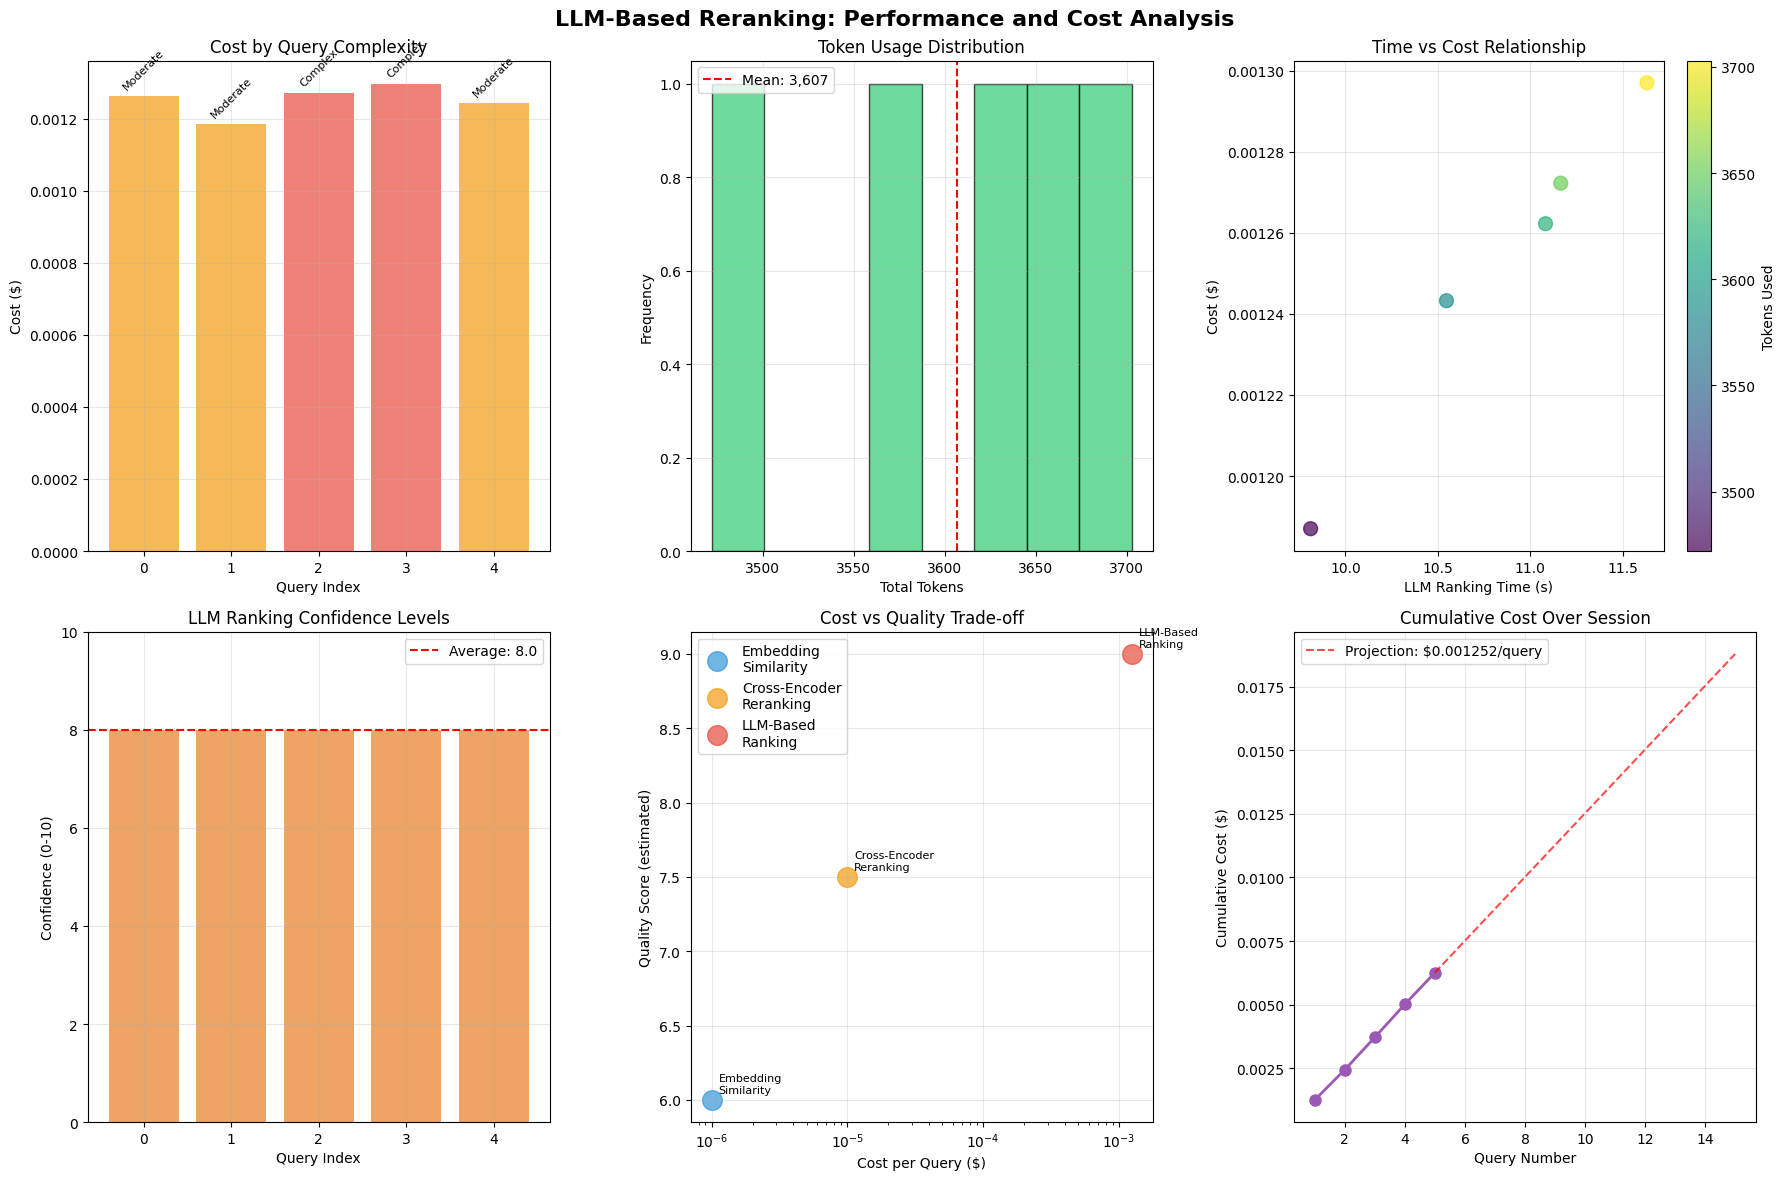

📊 Visualization complete!

Key insights from the analysis:
  • Average cost per query: $0.001252
  • Average confidence level: 8.0/10
  • Token usage varies with query complexity
  • LLM ranking provides highest quality but at higher cost
  • Most cost-effective for complex, high-value queries


In [18]:
# Create comprehensive visualizations
plt.style.use('default')
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('LLM-Based Reranking: Performance and Cost Analysis', fontsize=16, fontweight='bold')

# 1. Cost by Query Complexity
ax1 = axes[0, 0]
complexities = [r['complexity'] for r in cost_results]
costs = [r['cost'] for r in cost_results]
complexity_colors = {'simple': '#3498db', 'moderate': '#f39c12', 'complex': '#e74c3c', 'expert': '#9b59b6'}
colors = [complexity_colors.get(c, '#95a5a6') for c in complexities]

bars = ax1.bar(range(len(cost_results)), costs, color=colors, alpha=0.7)
ax1.set_xlabel('Query Index')
ax1.set_ylabel('Cost ($)')
ax1.set_title('Cost by Query Complexity')
ax1.grid(True, alpha=0.3)

# Add complexity labels
for i, (bar, complexity) in enumerate(zip(bars, complexities)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             complexity.title(), ha='center', va='bottom', rotation=45, fontsize=8)

# 2. Token Usage Distribution
ax2 = axes[0, 1]
tokens = [r['tokens'] for r in cost_results]
ax2.hist(tokens, bins=8, color='#2ecc71', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Total Tokens')
ax2.set_ylabel('Frequency')
ax2.set_title('Token Usage Distribution')
ax2.axvline(np.mean(tokens), color='red', linestyle='--', label=f'Mean: {np.mean(tokens):,.0f}')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Time vs Cost Relationship
ax3 = axes[0, 2]
llm_times = [r['llm_time'] for r in cost_results]
scatter = ax3.scatter(llm_times, costs, c=tokens, cmap='viridis', s=100, alpha=0.7)
ax3.set_xlabel('LLM Ranking Time (s)')
ax3.set_ylabel('Cost ($)')
ax3.set_title('Time vs Cost Relationship')
ax3.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax3, label='Tokens Used')

# 4. Confidence Levels
ax4 = axes[1, 0]
confidences = [r['confidence'] for r in cost_results]
ax4.bar(range(len(cost_results)), confidences, color='#e67e22', alpha=0.7)
ax4.set_xlabel('Query Index')
ax4.set_ylabel('Confidence (0-10)')
ax4.set_title('LLM Ranking Confidence Levels')
ax4.set_ylim(0, 10)
ax4.grid(True, alpha=0.3)

# Add average line
ax4.axhline(np.mean(confidences), color='red', linestyle='--', 
           label=f'Average: {np.mean(confidences):.1f}')
ax4.legend()

# 5. Cost-Effectiveness Comparison
ax5 = axes[1, 1]
methods = ['Embedding\nSimilarity', 'Cross-Encoder\nReranking', 'LLM-Based\nRanking']
approx_costs = [0.000001, 0.00001, np.mean(costs)]  # Approximate costs
quality_scores = [6, 7.5, 9]  # Estimated quality scores

# Create cost vs quality plot
colors_methods = ['#3498db', '#f39c12', '#e74c3c']
for i, (cost, quality, method, color) in enumerate(zip(approx_costs, quality_scores, methods, colors_methods)):
    ax5.scatter(cost, quality, s=200, c=color, alpha=0.7, label=method)
    ax5.annotate(method, (cost, quality), xytext=(5, 5), textcoords='offset points', fontsize=8)

ax5.set_xlabel('Cost per Query ($)')
ax5.set_ylabel('Quality Score (estimated)')
ax5.set_title('Cost vs Quality Trade-off')
ax5.set_xscale('log')
ax5.grid(True, alpha=0.3)
ax5.legend()

# 6. Cumulative Cost Over Session
ax6 = axes[1, 2]
cumulative_costs = np.cumsum([r['cost'] for r in cost_results])
ax6.plot(range(1, len(cumulative_costs) + 1), cumulative_costs, 'o-', 
         color='#9b59b6', linewidth=2, markersize=8)
ax6.set_xlabel('Query Number')
ax6.set_ylabel('Cumulative Cost ($)')
ax6.set_title('Cumulative Cost Over Session')
ax6.grid(True, alpha=0.3)

# Add cost projection
if len(cumulative_costs) > 1:
    avg_cost_per_query = cumulative_costs[-1] / len(cumulative_costs)
    projection_x = np.array([len(cumulative_costs), len(cumulative_costs) + 10])
    projection_y = avg_cost_per_query * projection_x
    ax6.plot(projection_x, projection_y, '--', color='red', alpha=0.7, 
            label=f'Projection: ${avg_cost_per_query:.6f}/query')
    ax6.legend()

plt.tight_layout()
plt.show()

print("📊 Visualization complete!")
print("\nKey insights from the analysis:")
print(f"  • Average cost per query: ${np.mean(costs):.6f}")
print(f"  • Average confidence level: {np.mean(confidences):.1f}/10")
print(f"  • Token usage varies with query complexity")
print(f"  • LLM ranking provides highest quality but at higher cost")
print(f"  • Most cost-effective for complex, high-value queries")

## 12. Interactive LLM-Based Ranking Demo

In [ ]:
# Final demonstration with a complex query
complex_query = "Compare the exploration strategies for Mars and Europa, focusing on the search for life"

print("🎯 FINAL DEMONSTRATION: Complex Query")
print("=" * 60)

final_result = rag_system.process_query(complex_query, retrieve_k=8, rerank_k=4)
display_results(final_result)

print("🎉 Semantic Reranking RAG System Demo Complete!")
print("\nThis notebook demonstrated:")
print("✅ Document embedding and indexing")
print("✅ Semantic similarity-based reranking")
print("✅ Integration with Gemini for explanations")
print("✅ Performance analysis and comparison")
print("✅ Complete RAG pipeline implementation")